# Практическая работа «Кластеризация. Метод k-средних»

## Цель практической работы

- Научиться строить модель кластеризации на реальных данных.

## Что входит в работу


- Загрузить данные и провести разведочный анализ.
- Предположить оптимальное количество кластеров.
- Построить модель кластеризации с помощью  библиотеки scikit-learn.
- Вычислить оптимальное количество кластеров.
- Интерпретировать результаты.

## Что оценивается

*   Выполнены все этапы задания.
*   Сделаны выводы по результатам.

## Как отправить работу на проверку

Скачайте файл с заданием в материалах, откройте его через Jupyter Notebook и выполните задачи. Сохраните изменения при помощи опции Save and Checkpoint из вкладки меню File или кнопки Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (с расширением .ipynb) или ссылку на него.


## Задача

Пусть имеется набор данных `Mall_Customers.csv` о покупателях супермаркета:

* CustomerID — идентификатор покупателя;
* Genre — пол;
* Age — возраст;
* Annual Income (k$) — годовой доход покупателя в тыс. долл.;
* Spending Score (1–100) — рейтинг трат покупателя.

Решите задачу кластеризации покупателей, чтобы в дальнейшем планировать маркетинговые акции для каждой группы.

In [121]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from ydata_profiling import ProfileReport

warnings.filterwarnings('ignore')
%matplotlib inline


### Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других обнаруженных свойствах данных.

In [122]:
df = pd.read_csv("Mall_Customers.csv")
df = df.rename(
    columns={
        "CustomerID": "id",
        "Genre": "sex",
        "Age": "age",
        "Annual Income (k$)": "income",
        "Spending Score (1-100)": "target",
    }
)

df = df.drop(columns=["id"])
df.head()

,sex,age,income,target
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [123]:
report = ProfileReport(df)
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Задание 2

Метод k-средних требует явно задать количество кластеров, на которые будут разбиваться данные. Поскольку данных может быть настолько много, что построение одной модели будет занимать несколько часов, важно примерно оценить количество кластеров до запуска обучения модели.

На основе результатов разведочного анализа данных предположите, какое количество кластеров будет оптимальным, и аргументируйте предположение.

### Задание 3

Преобразуйте категориальный признак Genre в численный. Аргументируйте выбор метода кодирования признака.

In [124]:
df.sex = (df.sex == 'Male').astype(int) # он самый простой
df.head()

,sex,age,income,target
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


### Задание 4

Постройте модель кластеризации с помощью метода k-средних. Определите оптимальное количество кластеров с помощью метода локтя.

In [125]:
X = df.iloc[:, [2, 3]].values

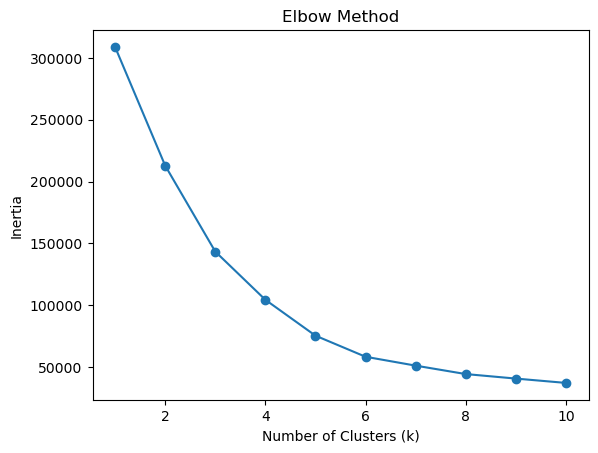

In [126]:
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=137)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.plot(k_values, inertia, "-o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

### Задание 5

Постройте финальную модель кластеризации с количеством кластеров, опредёленным в предыдущем задании.

**Учитывая, что мы уже построили по обязательной программе, пожалуй, перейдём к вольной. Найдём лучший $k$ с помощью индекса Силуэта.**

In [127]:
X_income = df.iloc[:, [2, 3]].values
X_age = df.iloc[:, [1, 3]].values

Best score 0.55, k = 5
Best score 0.5, k = 4


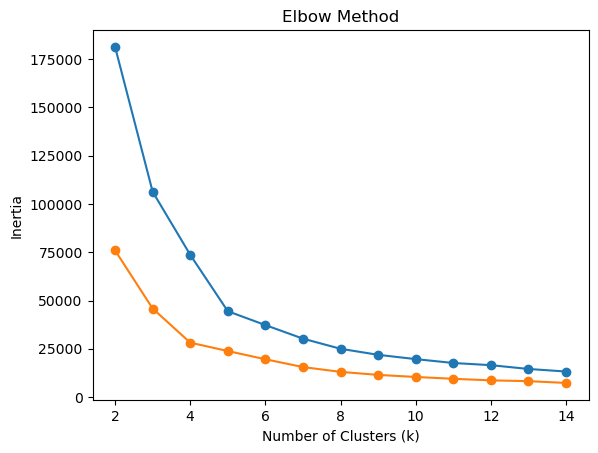

In [128]:
from sklearn.metrics import silhouette_score


def get_best_k(X):
    inertia = []
    k_values = range(2, 15)
    best_k, best_score = None, -1
    for k in k_values:
        k_means = KMeans(n_clusters=k)
        k_means = k_means.fit(X)
        inertia.append(k_means.inertia_)
        clusters = k_means.predict(X)
        score = np.round(silhouette_score(X=X, labels=clusters), 2)
        if score > best_score:
            best_score = score
            best_k = k
    print(f"Best score {best_score}, k = {best_k}")
    plt.plot(k_values, inertia, '-o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.title("Elbow Method")

get_best_k(X_income)
get_best_k(X_age)

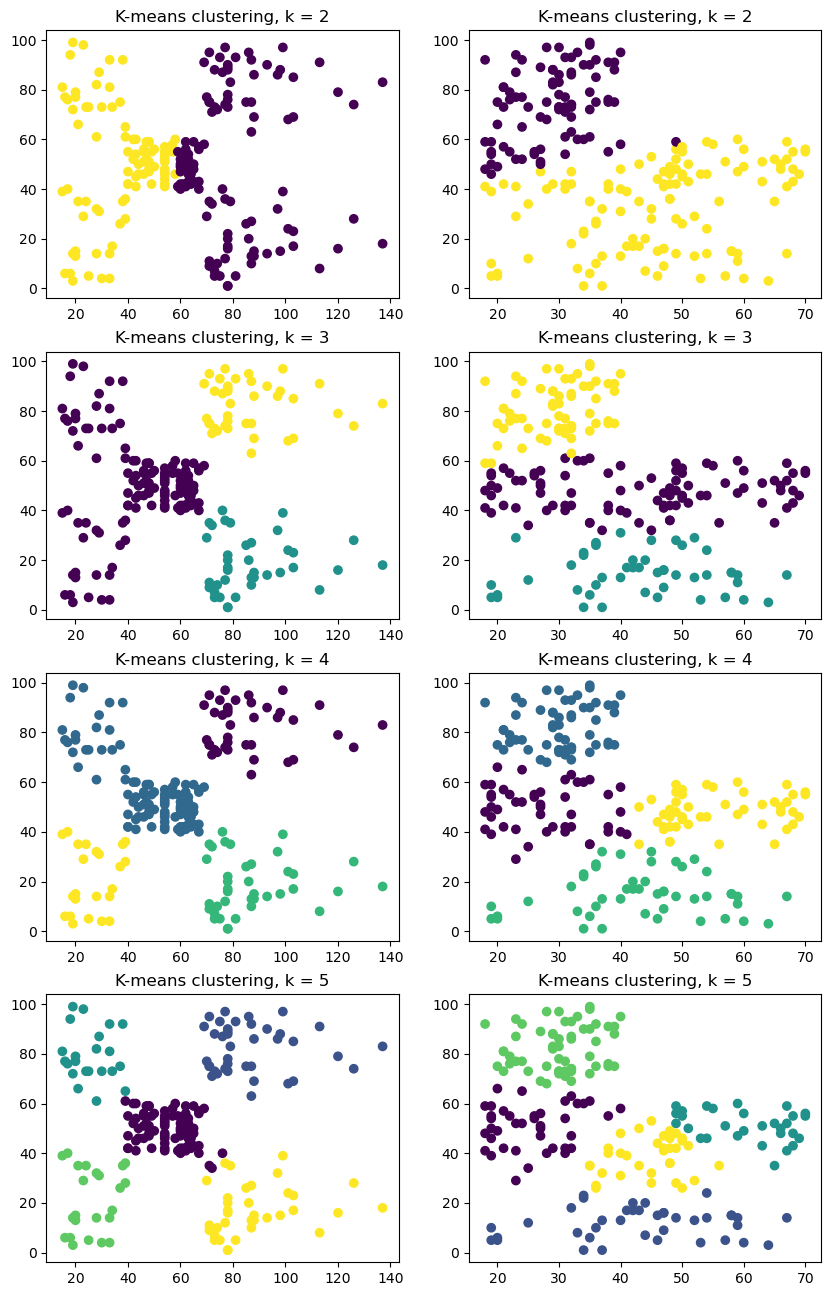

In [129]:

plt.figure(figsize=(10, 16))
i = 1
for k in range(2, 6):
    for X in [X_income, X_age]:
        k_means = KMeans(n_clusters = k)
        k_means = k_means.fit(X)
        clusters = k_means.predict(X)
        plt.subplot(4, 2, i)
        plt.scatter(X[:,0], X[:,1], c = clusters)
        plt.title(f'K-means clustering, k = {k}')
        i += 1
plt.show()


#### **Похоже, похоже. Действительно у дохода 5 кластеров, у возраста — 4.**

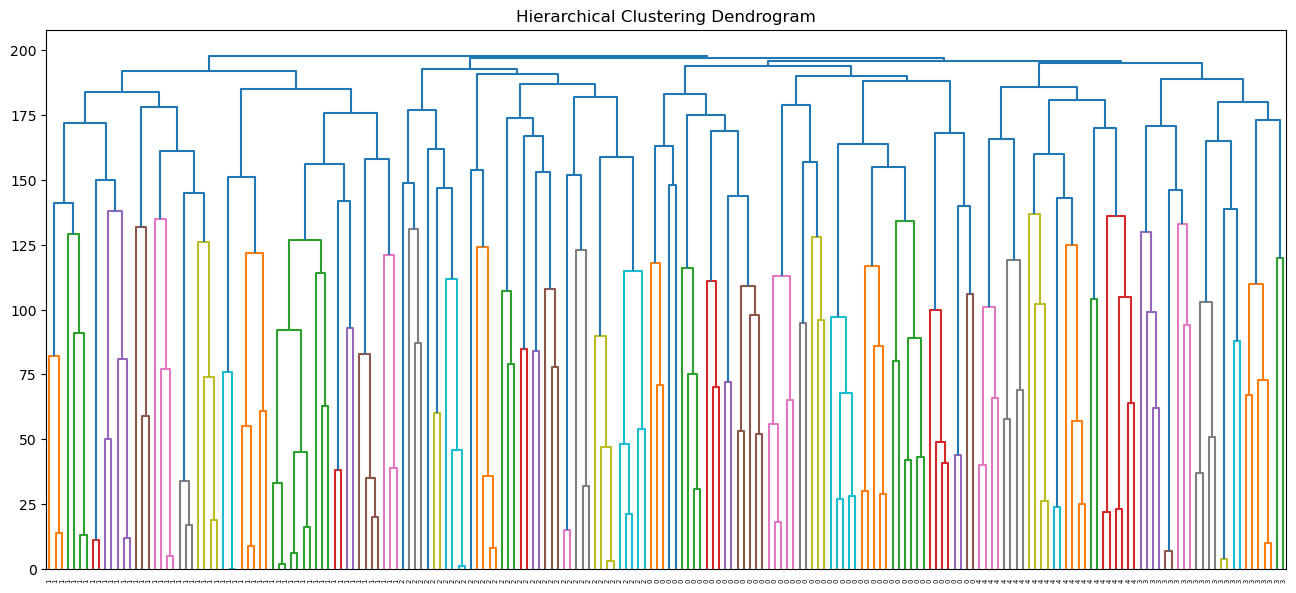

In [130]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    # linkage matrix format: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(n_clusters=5)

model = model.fit(X)
plt.figure(figsize=(16,7))
plot_dendrogram(model, labels=model.labels_)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

#### **Архидендрит какой-то получился. Не могу понять, а что на нём видно? В семинаре ВШЭ говорится, что количество кластеров определяется "по резкому скачку". А где здесь резкий скачок?**

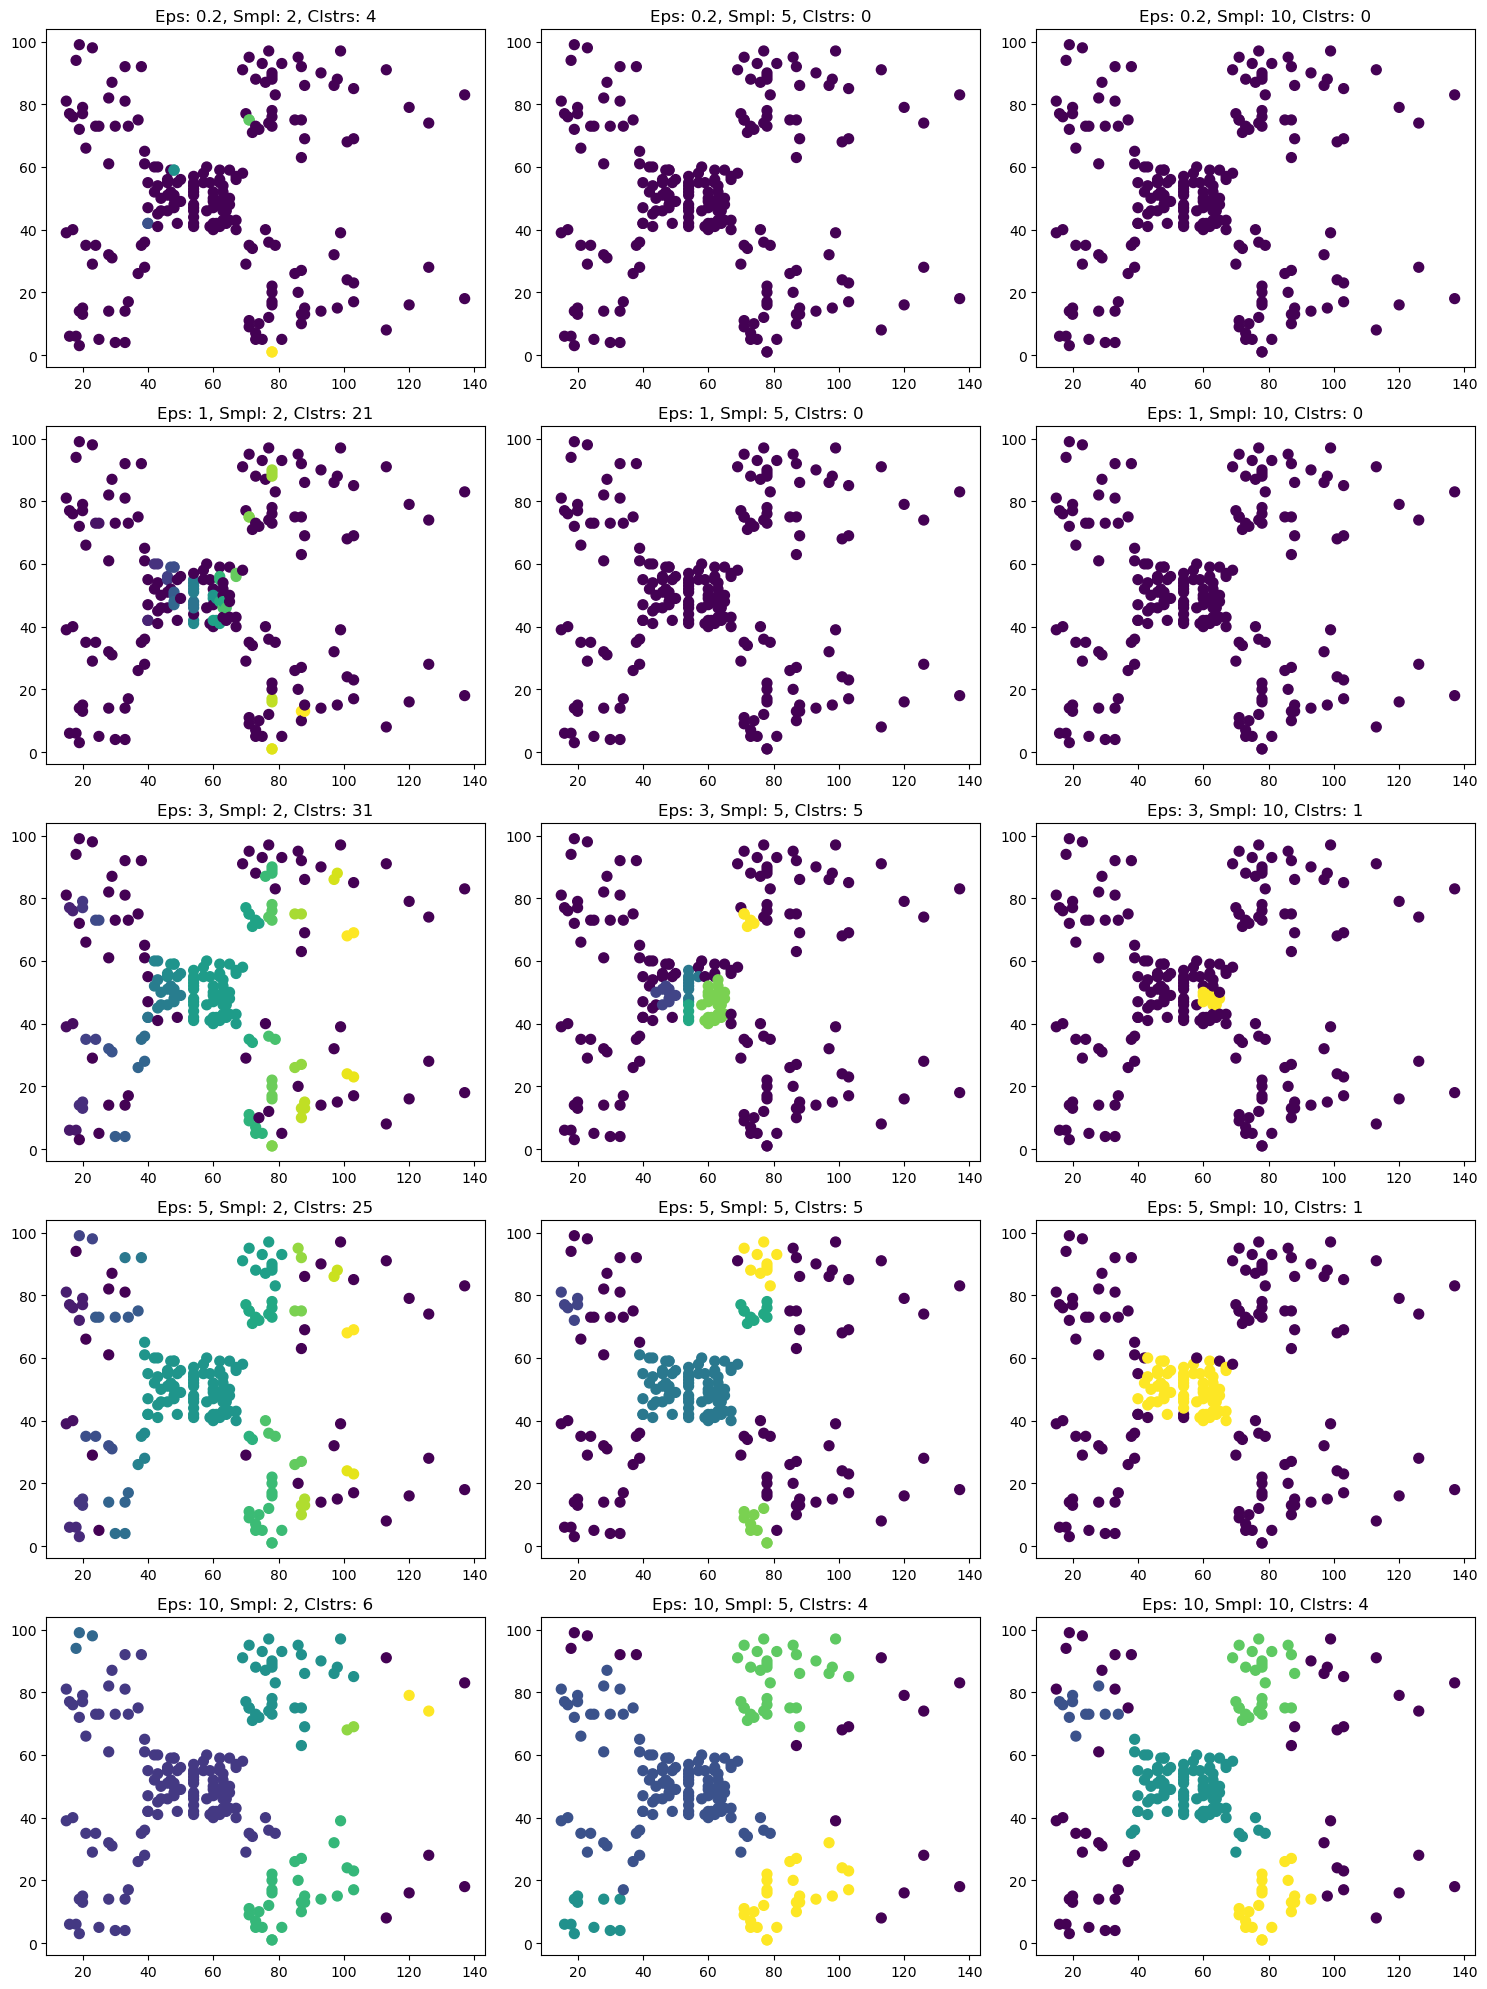

In [136]:
from sklearn.cluster import DBSCAN

X = df.iloc[:, [2, 3]].values

plt.figure(figsize=(15, 20))
i = 1 

for e in [0.2, 1, 3, 5, 10]:
    for samples in [2, 5, 10]:
        dbscan = DBSCAN(eps=e, min_samples=samples)
        clusters = dbscan.fit_predict(X)

        plt.subplot(5, 3, i)  # Определяем позицию подграфика
        plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap="viridis", s=50)
        n_clusters = len(np.unique(clusters[clusters != -1]))
        plt.title(f"Eps: {e}, Smpl: {samples}, Clstrs: {n_clusters}")
        i += 1

plt.tight_layout()
plt.show()


## **Мда, DBSCAN'у здесь очень тяжело. Хотя, как видно, датасет конкретно готовился под KMeans.**

### Задание 6 (выполните по желанию)

При работе с данными важно не только качество моделей машинного обучения, но и интерпретация полученных результатов и представление их в виде, понятном пользователям и заказчикам.

После построения модели кластеризации вы разбили покупателей на группы. Теперь важно интерпретировать эти группы, то есть создать профиль группы. 

В качестве профиля группы часто используют её типичного представителя. В кластерах типичным представителем можно назвать центроиду кластера. В sklearn получить список центроид можно с помощью атрибута `cluster_centers_` у объекта класса KMeans (этот атрибут возвращает матрицу с размерностями (количество кластеров, количество признаков), подробнее об этом [в материале](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)). 

Получите центроиды кластеров, преобразуйте их к датафрейму, опишите типичного представителя каждой группы и чем группы отличаются друг от друга. При описании и сравнении используйте методы визуализации.

In [132]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df)
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=["Sex", "Age", "Income", "Target"])
centroids_df

,Sex,Age,Income,Target
0,0.417722,43.088608,55.291139,49.569620
1,0.461538,32.692308,86.538462,82.128205
2,0.391304,25.521739,26.304348,78.565217
3,0.527778,40.666667,87.750000,17.583333
4,0.391304,45.217391,26.304348,20.913043


## **И тут на сцену выходит электронный болван:**

### **Анализ групп по центроидам кластеров**

#### **Описание групп**
Данные центроидов дают усреднённые значения характеристик для каждой группы. Рассмотрим типичного представителя каждой группы:

1. **Группа 0**:
   - **Пол (Sex):** 0.42 — примерно равное количество мужчин и женщин, с небольшим перевесом женщин.
   - **Возраст (Age):** 43 года — люди среднего возраста.
   - **Доход (Income):** 55.29 — доход на уровне среднего.
   - **Целевая переменная (Target):** 49.57 — средний отклик, около половины группы проявляет интерес.

2. **Группа 1**:
   - **Пол (Sex):** 0.46 — близкое соотношение полов, но чуть больше женщин.
   - **Возраст (Age):** 32 года — молодые взрослые.
   - **Доход (Income):** 86.54 — высокий доход.
   - **Целевая переменная (Target):** 82.13 — высокая заинтересованность в предложении.

3. **Группа 2**:
   - **Пол (Sex):** 0.53 — примерно равное количество мужчин и женщин, с небольшим перевесом мужчин.
   - **Возраст (Age):** 40 лет — ближе к среднему возрасту.
   - **Доход (Income):** 87.75 — высокий доход.
   - **Целевая переменная (Target):** 17.58 — низкий отклик на предложение.

4. **Группа 3**:
   - **Пол (Sex):** 0.39 — большинство женщин.
   - **Возраст (Age):** 25 лет — молодые люди.
   - **Доход (Income):** 26.30 — низкий доход.
   - **Целевая переменная (Target):** 78.57 — высокий отклик.

5. **Группа 4**:
   - **Пол (Sex):** 0.39 — большинство женщин.
   - **Возраст (Age):** 45 лет — люди среднего возраста.
   - **Доход (Income):** 26.30 — низкий доход.
   - **Целевая переменная (Target):** 20.91 — низкий отклик.

---

#### **Сравнение групп**
- **Группы 1 и 2:** 
  - Обе имеют высокий доход ($> 85$), но сильно отличаются по интересу: в группе 1 высокая заинтересованность ($82.13$), а в группе 2 — низкая ($17.58$).
- **Группы 3 и 4:** 
  - Обе группы с низким доходом ($\approx 26.3$), но различаются по возрасту и интересу. Молодые люди из группы 3 проявляют высокий интерес ($78.57$), а группа 4 с более старшим возрастом — низкий ($20.91$).
- **Группа 0:** 
  - Средний доход ($55.29$), средний возраст ($43$) и нейтральный интерес ($49.57$).

---

### **Визуализация данных**

#### **1. Барплоты для характеристик**
Создаём визуализацию основных характеристик по группам.


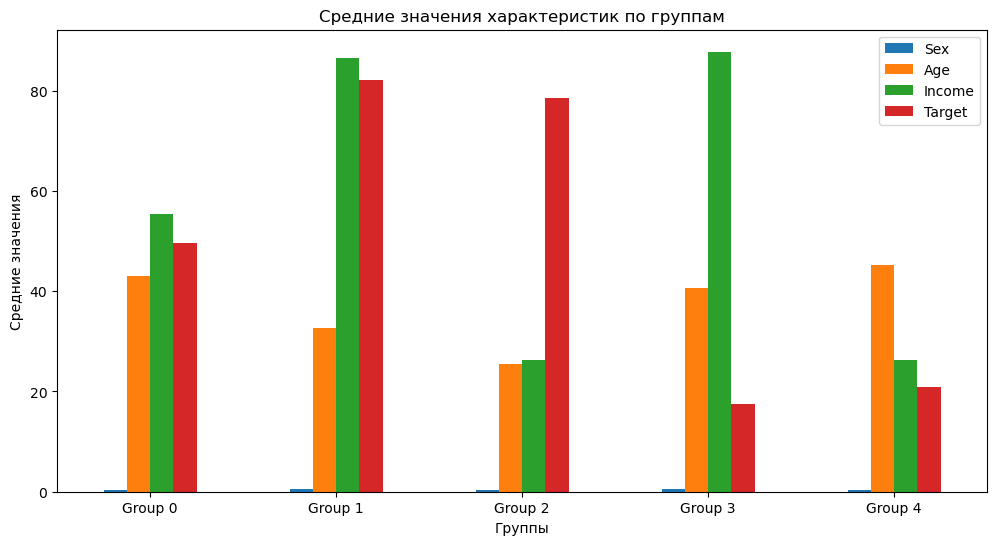

In [133]:

# Визуализация
centroids_df.plot(kind='bar', figsize=(12, 6))
plt.xticks(range(len(centroids_df)), labels=[f"Group {i}" for i in range(5)], rotation=0)
plt.title("Средние значения характеристик по группам")
plt.ylabel("Средние значения")
plt.xlabel("Группы")
plt.legend(loc="best")
plt.show()

#### **2. Scatter plot для дохода и целевого отклика**
Эта визуализация показывает, как интерес связан с доходом.

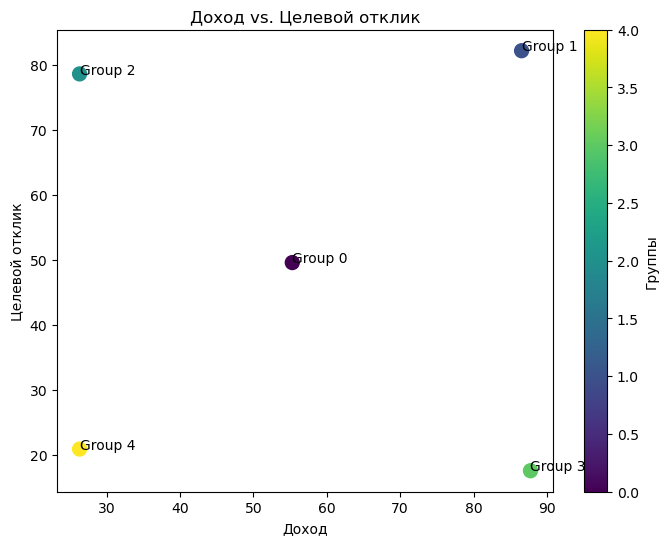

In [134]:
plt.figure(figsize=(8, 6))
plt.scatter(centroids_df['Income'], centroids_df['Target'], s=100, c=range(5), cmap="viridis")
for i, (income, target) in enumerate(zip(centroids_df['Income'], centroids_df['Target'])):
    plt.text(income, target, f"Group {i}", fontsize=10)
plt.title("Доход vs. Целевой отклик")
plt.xlabel("Доход")
plt.ylabel("Целевой отклик")
plt.colorbar(label="Группы")
plt.show()


#### **3. Boxplot для возрастных различий**
Сравнение возрастных характеристик.


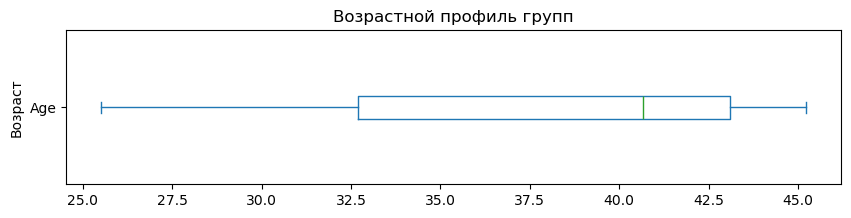

In [135]:
centroids_df[['Age']].plot(kind='box', figsize=(10, 2), vert=False)
plt.title("Возрастной профиль групп")
plt.ylabel("Возраст")
plt.show()

### **Выводы**
1. Группы можно разделить на:
   - **Высокодоходные (1 и 2)**: разный интерес при схожем доходе.
   - **Низкодоходные (3 и 4)**: различия в интересе связаны с возрастом.
   - **Среднедоходная группа (0)**: нейтральный интерес и средние характеристики.
2. **Доход и целевой отклик не всегда коррелируют**: группы с высоким доходом (1 и 2) отличаются по отклику.
3. **Возраст влияет на интерес**: молодые люди (группа 3) с низким доходом более заинтересованы.

**Мдаааа. Есть вещи, которые электронный болван делает сильно лучше меня. И, видимо, в дальнейшем этот разрыв будет только увеличиваться.**